# 1. Introduction

In this tutorial, we demonstrate how to use Normet to perform weather normalisation of a target variable (e.g., pollutant concentration, energy demand, sales) using two AutoML backends: FLAML and H2O.

We will cover:
- Training FLAML and H2O models for weather normalisation.
- Saving and reloading models.
- Applying rolling weather normalisation to handle temporal drift.

# 2. Load Dataset

In [4]:
import pandas as pd

df_pre = pd.read_csv("data_df_prep.csv",parse_dates=['date'],index_col='date')

df_pre.head()

,blh,d2m,rh2m,sp,ssrd,t2m,tcc,tp,u10,v10,value,date_unix,day_julian,weekday,hour,set
date,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,384.209053,277.183465,91.884130,102252.303312,-1.164153e-10,278.394725,0.650958,0.000008,-2.720528,1.545010,58.1,1577836800,1,3,0,training
2020-01-01 01:00:00,353.220263,276.695430,92.715877,102211.168636,-1.164153e-10,277.772899,0.603699,0.000002,-2.308789,1.282742,43.2,1577840400,1,3,1,training
2020-01-01 02:00:00,255.911846,276.505662,93.485560,102174.855967,-1.164153e-10,277.463419,0.710378,0.000005,-2.216471,0.758730,43.0,1577844000,1,3,2,testing
2020-01-01 03:00:00,191.375560,276.412816,93.906363,102166.786485,-1.164153e-10,277.305813,0.837765,0.000005,-1.928623,0.509013,42.8,1577847600,1,3,3,training
2020-01-01 04:00:00,151.780210,276.553051,93.696878,102142.578039,-1.164153e-10,277.478941,0.819103,0.000003,-1.700043,0.607069,36.8,1577851200,1,3,4,testing


Expected columns:
- pollutant (target variable to normalise)
- temperature, wind_speed, humidity (predictor variables)
- Optional: set column to indicate training/test split

# 3. Weather normalisation

# 3.1 Weather normalisation with FLAML

In [5]:
#Load pre trained model
import normet as nm
from normet.utils.logging import enable_default_logging, get_logger
enable_default_logging(level="INFO")
log = get_logger("tutorial.model_training")


In [6]:
model_flaml=nm.load_model(folder_path='.',filename='automl.joblib')
df_dew=nm.normalise(df_pre, model_flaml,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=True)

INFO | normet.normet.backends.flaml_backend | Loaded FLAML model from automl.joblib
INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=True, memory_save=False, n_cores=7).
INFO | normet.normet.analysis.normalise | Aggregating 300 predictions.
INFO | normet.normet.analysis.normalise | Finished normalisation.


In [7]:
df_dew.head()

,observed,normalised
date,,
2020-01-01 00:00:00,58.1,27.182170
2020-01-01 01:00:00,43.2,25.958245
2020-01-01 02:00:00,43.0,25.749106
2020-01-01 03:00:00,42.8,25.697841
2020-01-01 04:00:00,36.8,26.751151


<Axes: xlabel='date'>

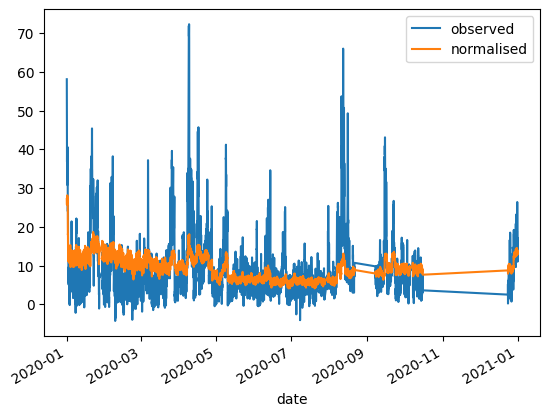

In [8]:
import matplotlib.pyplot as plt
import matplotlib
df_dew.plot()

In [9]:
df_dew_seed=nm.normalise(df_pre, model_flaml,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=False)

INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=False, memory_save=False, n_cores=7).
INFO | normet.normet.analysis.normalise | Finished normalisation.


In [10]:
df_dew_seed.head()

,observed,2406,5035,6374,15807,20564,21247,22819,24892,27540,...,970632,972475,973261,973405,977095,985695,987065,991790,992444,994420
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,25.334665,19.801159,17.220090,24.203985,20.853967,17.527022,41.264985,40.642769,18.466309,...,29.724612,19.209057,19.869041,24.730700,23.377378,19.491963,19.609632,19.223046,39.603922,19.256324
2020-01-01 01:00:00,43.2,20.914917,17.712334,20.483299,24.149660,20.715367,31.451928,22.809387,22.640408,17.279074,...,25.300950,16.731467,26.652703,24.916386,21.707955,18.776439,23.956059,26.166405,36.724304,17.029867
2020-01-01 02:00:00,43.0,24.138534,26.284536,18.503286,20.426364,21.868111,19.758168,27.376477,39.910095,18.357631,...,31.121856,25.203257,22.514545,21.676706,31.098581,26.688252,20.605833,31.294024,38.062998,16.996398
2020-01-01 03:00:00,42.8,39.946319,22.819175,32.404621,29.147484,22.157553,17.766601,32.616876,21.863855,20.171983,...,19.913979,34.492893,21.328577,34.476583,33.412035,18.419028,33.720562,35.210703,14.252220,26.694316
2020-01-01 04:00:00,36.8,31.139116,30.606937,26.112993,18.822054,13.654114,31.275918,18.517598,23.512123,18.511426,...,41.819150,24.199639,28.388028,35.781977,31.685945,28.612228,20.086880,32.802659,14.918671,20.293553


# 3.2 Weather normalisation with H2O

In [11]:
model_h2o=nm.load_model(folder_path='.',backend='h2o',filename='automl')

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 min 46 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.073 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=8G
INFO | normet.normet.backends.h2o_backend | Loaded H2O model from automl


In [12]:
df_dew_h2o=nm.normalise(df_pre, model_h2o,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=True)

INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=True, memory_save=False, n_cores=7).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.analysis.normalise | Aggregating 300 predictions.
INFO | normet.normet.analysis.normalise | Finished normalisation.


<Axes: xlabel='date'>

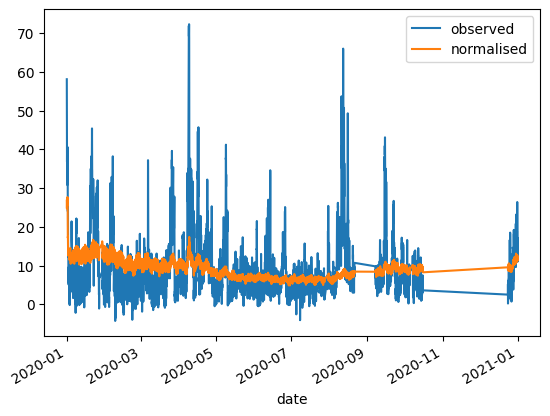

In [13]:
df_dew_h2o.plot()

<Axes: xlabel='date'>

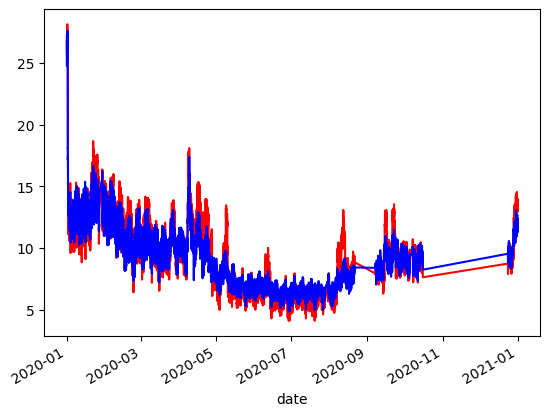

In [14]:
fig,ax=plt.subplots()
df_dew['normalised'].plot(c='r')
df_dew_h2o['normalised'].plot(c='b')

In [15]:
df_dew_seed_h2o=nm.normalise(df_pre, model_h2o,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=False)

INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=False, memory_save=False, n_cores=7).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.analysis.normalise | Finished normalisation.


In [16]:
df_dew_seed_h2o.head()

,observed,2406,5035,6374,15807,20564,21247,22819,24892,27540,...,970632,972475,973261,973405,977095,985695,987065,991790,992444,994420
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,31.504189,20.414587,18.083072,21.339616,20.424616,18.157412,43.128336,35.706135,18.903136,...,32.764028,19.229065,20.300397,23.318338,19.142890,25.989570,20.041953,19.808668,37.306470,17.424988
2020-01-01 01:00:00,43.2,19.090920,18.102829,18.288426,25.785176,19.351284,30.866796,20.415654,20.526999,18.822100,...,30.340273,18.191081,27.621859,28.348250,19.611790,19.870589,24.189239,25.669854,34.703970,18.412889
2020-01-01 02:00:00,43.0,31.094905,28.304649,16.106335,18.526368,26.953414,15.815412,30.236498,39.404132,18.173242,...,33.675859,20.802845,22.074747,18.458119,30.544938,29.381734,27.595213,27.946886,38.314076,22.428825
2020-01-01 03:00:00,42.8,29.548160,18.602961,29.157370,25.976176,19.171789,16.899817,27.948245,21.786801,18.376024,...,18.598439,31.296849,16.796908,32.651537,32.816758,22.966758,28.620076,25.617817,13.416565,29.381122
2020-01-01 04:00:00,36.8,32.923254,28.446938,25.376369,18.360805,13.966657,28.675692,19.087067,18.090271,20.729591,...,38.134984,18.296383,27.797183,34.069262,29.266358,25.408461,19.151394,33.295785,15.706879,19.124315


# 3.3 Weather normalisation with user-defined weather dataset

In [17]:
# Selected weather dataset
weather_df=df_pre.reset_index().iloc[0:100][['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m']]

In [18]:
weather_df

,u10,v10,d2m,t2m,blh,sp,ssrd,tcc,tp,rh2m
0,-2.720528,1.545010,277.183465,278.394725,384.209053,102252.303312,-1.164153e-10,0.650958,8.122856e-06,91.884130
1,-2.308789,1.282742,276.695430,277.772899,353.220263,102211.168636,-1.164153e-10,0.603699,2.233786e-06,92.715877
2,-2.216471,0.758730,276.505662,277.463419,255.911846,102174.855967,-1.164153e-10,0.710378,4.975250e-06,93.485560
3,-1.928623,0.509013,276.412816,277.305813,191.375560,102166.786485,-1.164153e-10,0.837765,4.873714e-06,93.906363
4,-1.700043,0.607069,276.553051,277.478941,151.780210,102142.578039,-1.164153e-10,0.819103,2.995303e-06,93.696878
...,...,...,...,...,...,...,...,...,...,...
95,2.382450,0.898623,277.286818,278.536809,159.740633,102677.427238,-1.164153e-10,0.665897,0.000000e+00,91.643696
96,1.953356,3.282828,278.385969,280.142238,577.792066,102066.508411,-1.164153e-10,0.992543,3.046071e-07,88.578482
97,2.152209,3.542742,278.420706,280.367661,720.511077,102008.250688,-1.164153e-10,1.000005,5.584464e-07,87.431927
98,2.212770,3.903066,278.022302,280.524312,828.002633,101947.729573,-1.164153e-10,0.993077,1.015357e-07,84.133213


In [19]:
# Weather normalisation using flaml
df_dew_a=nm.normalise(df_pre, model_flaml,weather_df=weather_df,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=True)

INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=True, memory_save=False, n_cores=7).
INFO | normet.normet.analysis.normalise | Aggregating 300 predictions.
INFO | normet.normet.analysis.normalise | Finished normalisation.


In [20]:
# Weather normalisation using h2o
df_dew_b=nm.normalise(df_pre, model_h2o,weather_df=weather_df,
                           feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'], #features used for model training
                          variables_resample= ['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], #variables for resampling
                          n_samples=300,aggregate=True)

INFO | normet.normet.analysis.normalise | Normalising with 300 resamples (aggregate=True, memory_save=False, n_cores=7).
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.analysis.normalise | Aggregating 300 predictions.
INFO | normet.normet.analysis.normalise | Finished normalisation.


<Axes: xlabel='date'>

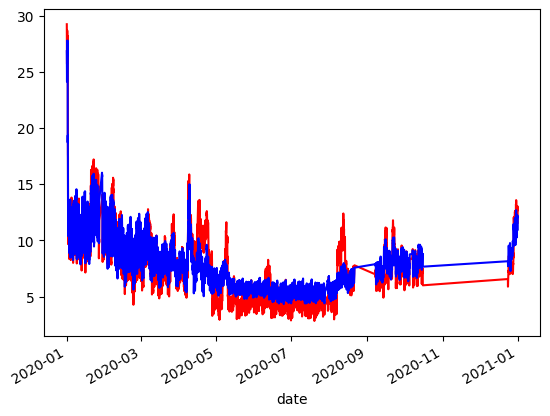

In [21]:
#Flaml vs. h2o
fig,ax=plt.subplots()
df_dew_a['normalised'].plot(c='r')
df_dew_b['normalised'].plot(c='b')

<Axes: xlabel='date'>

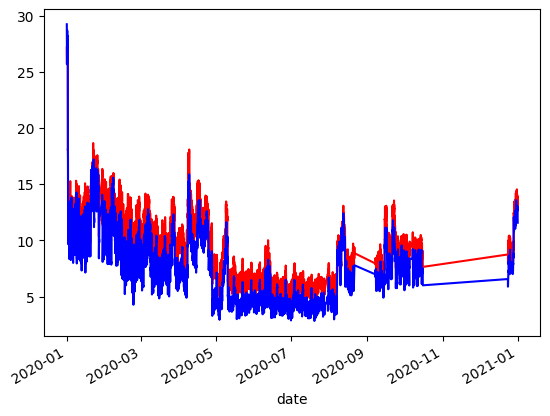

In [22]:
#Whole weather dataset vs. selected weather dataset using flaml
fig,ax=plt.subplots()
df_dew['normalised'].plot(c='r')
df_dew_a['normalised'].plot(c='b')

<Axes: xlabel='date'>

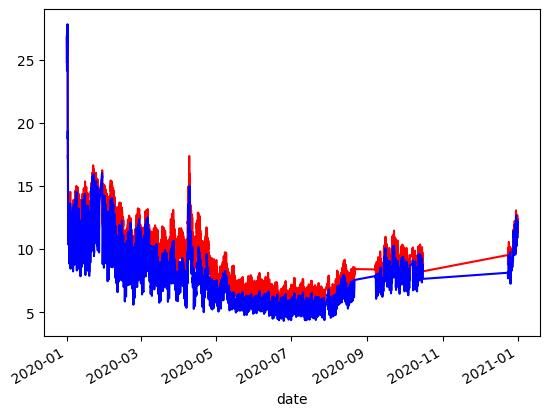

In [23]:
#Whole weather dataset vs. selected weather dataset using h2o
fig,ax=plt.subplots()
df_dew_h2o['normalised'].plot(c='r')
df_dew_b['normalised'].plot(c='b')

# 4. Rolling weather normalisation

In [24]:
#Rolling based on flaml model
df_dew_rolling=nm.rolling(df_pre,value='value', model=model_flaml,feature_names=['u10', 'v10', 'd2m', 't2m',
                                                             'blh', 'sp', 'ssrd', 'tcc', 
                                                             'tp', 'rh2m','date_unix',
                                                             'day_julian', 'weekday','hour'],
                    variables_resample=['u10', 'v10', 'd2m', 't2m','blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], 
                    n_samples=100,window_days=14, rolling_every=7)

INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:06: window 0/50 [2020-01-01..2020-01-14] | ETA 15.1s
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:08: window 9/50 [2020-03-04..2020-03-17] | ETA 11.9s
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:11: window 19/50 [2020-05-13..2020-05-26] | ETA 9.0s
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:14: window 29/50 [2020-07-22..2020-08-04] | ETA 6.0s
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:16: window 39/50 [2020-09-30..2020-10-13] | ETA 3.0s
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:16: window 42 skipped (not enough rows).
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:16: window 43 skipped (not enough rows).
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:16: window 44 skipped (not enough rows).
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:16: window 45 skipped (not enough rows).
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:1

In [25]:
df_dew_rolling.head()

,observed,rolling_0,rolling_1,rolling_2,rolling_3,rolling_4,rolling_5,rolling_6,rolling_7,rolling_8,...,rolling_33,rolling_34,rolling_35,rolling_36,rolling_37,rolling_38,rolling_39,rolling_40,rolling_41,rolling_50
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,24.487918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 01:00:00,43.2,23.630877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 02:00:00,43.0,24.204709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 03:00:00,42.8,22.730674,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,36.8,22.610567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: xlabel='date'>

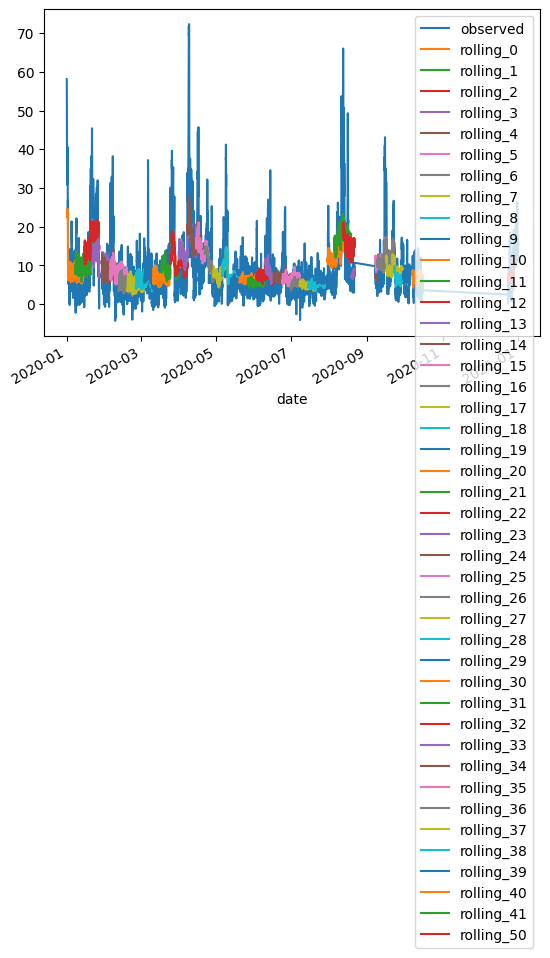

In [26]:
df_dew_rolling.plot()

In [27]:
#Rolling based on h2o model
df_dew_rolling_h2o=nm.rolling(df_pre,value='value', model=model_h2o,feature_names=['u10', 'v10', 'd2m', 't2m',
                                                             'blh', 'sp', 'ssrd', 'tcc', 
                                                             'tp', 'rh2m','date_unix',
                                                             'day_julian', 'weekday','hour'],
                    variables_resample=['u10', 'v10', 'd2m', 't2m','blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'], 
                    n_samples=100,window_days=14, rolling_every=7)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.analysis.rolling | 2025-09-17 15:26:19: window 0/50 [2020-01-01..2020-01-14] | ETA 1.3m
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |███████████████████

<Axes: xlabel='date'>

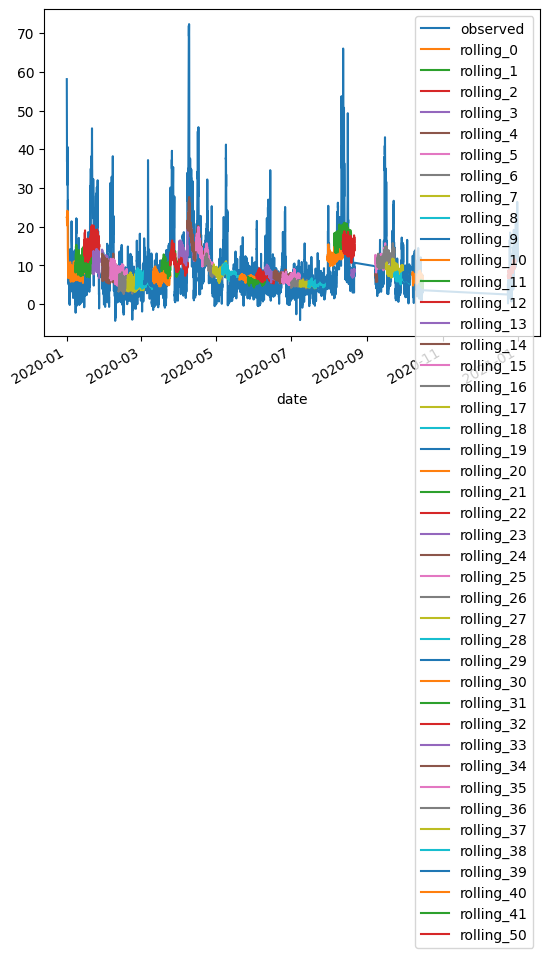

In [28]:
df_dew_rolling_h2o.plot()

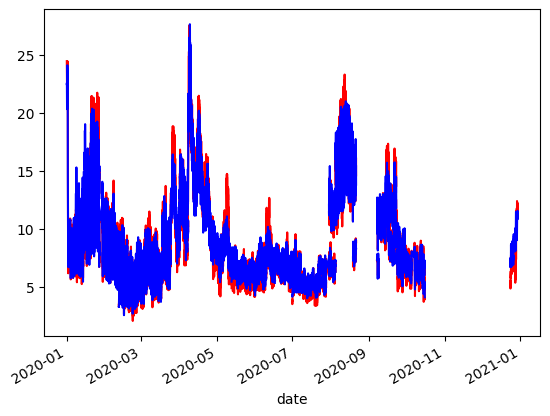

In [29]:
fig,ax=plt.subplots()
df_dew_rolling.iloc[:,1:].plot(c='r',ax=ax)
df_dew_rolling_h2o.iloc[:,1:].plot(c='b',ax=ax)
ax.legend().set_visible(False) 

# 5. Automated pipeline from data preparation to weather normalisation

In [30]:
df=pd.read_csv(r'data_MY1_data.csv',parse_dates=['date'],index_col='date')

In [31]:
#do_all function, using flaml backend as default
df_dew, model_flaml, df_pre = nm.do_all(
    df,
    value="PM2.5",
    feature_names=[
        "u10","v10","d2m","t2m","blh","sp","ssrd","tcc","tp","rh2m",
        "date_unix","day_julian","weekday","hour" 
    ],
    variables_resample=["u10","v10","d2m","t2m","blh","sp","ssrd","tcc","tp","rh2m"],              
    n_samples=300
)

INFO | normet.normet.pipeline.do_all | Starting do_all | backend=flaml | value=PM2.5 | n_samples=300
INFO | normet.normet.utils.prepare | Dropped 2411 rows with NA in target.
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.pipeline.do_all | Data prepared: 6373 rows (4780 training, 1593 testing)
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.backends.flaml_backend | Training FLAML AutoML: X shape=(4780, 14), target='value'
INFO | normet.normet.backends.flaml_backend | FLAML best_estimator=lgbm | best_config={'n_estimators': 74, 'num_leaves': 75, 'min_child_samples': 12, 'learning_rate': np.float64(0.17117872176616736), 'log_max_bin': 8, 'colsample_bytree': np.float64(0.8870555861638901), 'reg_alpha': np.float64(0.3446922903067839), 'reg_lambda': np.float64(3.5873941309408157)}
INFO | normet.normet.model.train | Model trained with backend=flaml
INFO | normet.normet.pipeline.do_all | Model train

In [32]:
#using h2o backend
df_dew_h2o, model_h2o, df_pre_h2o = nm.do_all(
    df,
    value="PM2.5",backend='h2o',
    feature_names=[
        "u10","v10","d2m","t2m","blh","sp","ssrd","tcc","tp","rh2m",
        "date_unix","day_julian","weekday","hour" 
    ],
    variables_resample=["u10","v10","d2m","t2m","blh","sp","ssrd","tcc","tp","rh2m"],              
    n_samples=300
)

INFO | normet.normet.pipeline.do_all | Starting do_all | backend=h2o | value=PM2.5 | n_samples=300
INFO | normet.normet.utils.prepare | Dropped 2411 rows with NA in target.
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.pipeline.do_all | Data prepared: 6373 rows (4780 training, 1593 testing)
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,6 mins 41 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.771 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.backends.h2o_backend | Training H2O AutoML: X=14 cols, target='value' (max_models=10, nfolds=5, include_algos=['GBM'])
AutoML progress: |
15:28:54.26: Project: AutoML_2_20250917_152854
15:28:54.27: Setting stopping tolerance adaptively based on the training frame: 0.014463921353509292
15:28:54.27: Build control seed: 7654321
15:28:54.27: training frame: Frame key: AutoML_2_20250917_152854_training_py_14_sid_abf1    cols: 15    rows: 4780  chunks: 1    size: 431236  checksum: 4697081988121428448
15:28:54.27: validation frame: NULL
15:28:54.27: leaderboard frame: NULL
15:28:54.27: blending frame: NULL
15:28:54.27: response column: value
15:28:54.27: fold column: null
15:28:54.27: weights column: null
15:28:54.27: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 

# 6. Uncertainty of normalised data

In [33]:
df_dew_unc, mod_stats_unc=nm.do_all_unc(df,value='PM2.5',feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'],n_samples=100,n_models=5)

INFO | normet.normet.pipeline.do_all | do_all_unc: running model 1/5 (seed=167067) 
INFO | normet.normet.pipeline.do_all | Starting do_all | backend=flaml | value=PM2.5 | n_samples=100
INFO | normet.normet.utils.prepare | Dropped 2411 rows with NA in target.
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.pipeline.do_all | Data prepared: 6373 rows (4780 training, 1593 testing)
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.model.train | Model trained with backend=flaml
INFO | normet.normet.pipeline.do_all | Model trained with backend=flaml
INFO | normet.normet.pipeline.do_all | do_all finished: 6373 timestamps
INFO | normet.normet.pipeline.do_all | do_all_unc: running model 2/5 (seed=607885) ETA 6.6m
INFO | normet.normet.pipeline.do_all | Starting do_all | backend=flaml | value=PM2.5 | n_samples=100
INFO | normet.normet.utils.prepare | Dropped 2411 rows with NA in target.
INFO | normet.normet

In [34]:
df_dew_unc_h2o, mod_stats_unc_h2o=nm.do_all_unc(df,value='PM2.5',feature_names=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m','date_unix', 'day_julian', 'weekday',
       'hour'],variables_resample=['u10', 'v10', 'd2m', 't2m',
       'blh', 'sp', 'ssrd', 'tcc', 'tp', 'rh2m'],n_samples=100,n_models=5,backend='h2o')

INFO | normet.normet.pipeline.do_all | do_all_unc: running model 1/5 (seed=167067) 
INFO | normet.normet.pipeline.do_all | Starting do_all | backend=h2o | value=PM2.5 | n_samples=100
INFO | normet.normet.utils.prepare | Dropped 2411 rows with NA in target.
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
INFO | normet.normet.pipeline.do_all | Data prepared: 6373 rows (4780 training, 1593 testing)
INFO | normet.normet.utils.prepare | Prepared data: 6373 rows, 17 columns
Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,15 mins 40 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.937 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.model.train | Model trained with backend=h2o
INFO | normet.normet.pipeline.do_all | Model trained with backend=h2o
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse p

H2O_cluster_uptime:,16 mins 18 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.710 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.model.train | Model trained with backend=h2o
INFO | normet.normet.pipeline.do_all | Model trained with backend=h2o
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse p

H2O_cluster_uptime:,16 mins 53 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.683 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.model.train | Model trained with backend=h2o
INFO | normet.normet.pipeline.do_all | Model trained with backend=h2o
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse p

H2O_cluster_uptime:,17 mins 27 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.812 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.model.train | Model trained with backend=h2o
INFO | normet.normet.pipeline.do_all | Model trained with backend=h2o
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse p

H2O_cluster_uptime:,18 mins 02 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 20 days
H2O_cluster_name:,H2O_from_python_n94921cs_kx5ykh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.721 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,7
H2O_cluster_status:,"locked, healthy"


INFO | normet.normet.backends.h2o_backend | H2O cluster up | version=None | nthreads=? | mem=16G
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%
INFO | normet.normet.model.train | Model trained with backend=h2o
INFO | normet.normet.pipeline.do_all | Model trained with backend=h2o
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Parse p

In [35]:
df_dew_unc.head()

,observed,normalised_167067,normalised_607885,normalised_853045,normalised_528157,normalised_806796,mean,std,median,lower_bound,upper_bound,weighted
date,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,29.922276,16.711544,17.724123,14.598821,19.344768,19.660306,5.988953,17.724123,14.810093,28.864525,19.772348
2020-01-01 01:00:00,43.2,28.438167,15.931471,17.923854,12.307041,17.537946,18.427696,6.019730,17.537946,12.669484,27.386735,18.492012
2020-01-01 02:00:00,43.0,27.873004,14.416431,17.439856,13.189763,18.454046,18.274620,5.779260,17.439856,13.312430,26.931108,18.385445
2020-01-01 03:00:00,42.8,26.992285,14.182275,18.174860,10.428063,18.765495,17.708596,6.183899,18.174860,10.803485,26.169606,17.777308
2020-01-01 04:00:00,36.8,27.707221,15.391197,17.579935,9.860057,16.997983,17.507279,6.466477,16.997983,10.413171,26.694492,17.545756


In [36]:
df_dew_unc_h2o.head()

,observed,normalised_167067,normalised_607885,normalised_853045,normalised_528157,normalised_806796,mean,std,median,lower_bound,upper_bound,weighted
date,,,,,,,,,,,,
2020-01-01 00:00:00,58.1,27.594043,19.405514,19.713680,26.625296,25.339100,23.735527,3.896621,25.339100,19.436331,27.497168,23.910196
2020-01-01 01:00:00,43.2,26.293301,18.845965,20.116976,25.002331,24.796120,23.010939,3.303349,24.796120,18.973066,26.164204,23.158851
2020-01-01 02:00:00,43.0,25.250133,17.868630,19.618194,26.307529,25.279510,22.864799,3.836509,25.250133,18.043586,26.204727,23.037059
2020-01-01 03:00:00,42.8,24.292013,17.534200,20.226138,23.695257,25.416020,22.232726,3.264030,23.695257,17.803394,25.303619,22.374203
2020-01-01 04:00:00,36.8,23.950624,17.882538,19.117345,22.661512,24.266828,21.575769,2.904496,22.661512,18.006019,24.235208,21.705928


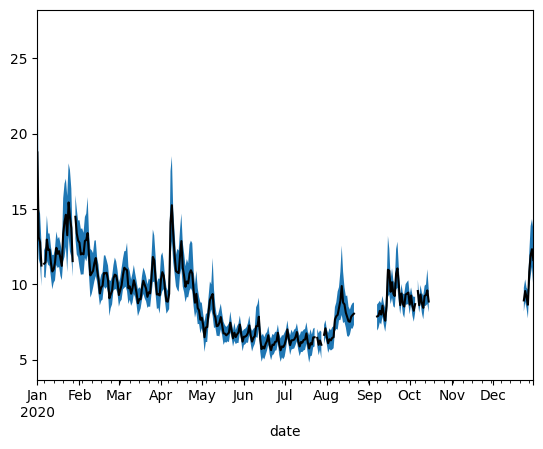

In [40]:
fig,ax=plt.subplots()
df_dew_unc.resample('1D').mean()['mean'].plot(c='k')
ax.fill_between(df_dew_unc.resample('1D').mean().index,df_dew_unc.resample('1D').mean()['lower_bound'],df_dew_unc.resample('1D').mean()['upper_bound'])


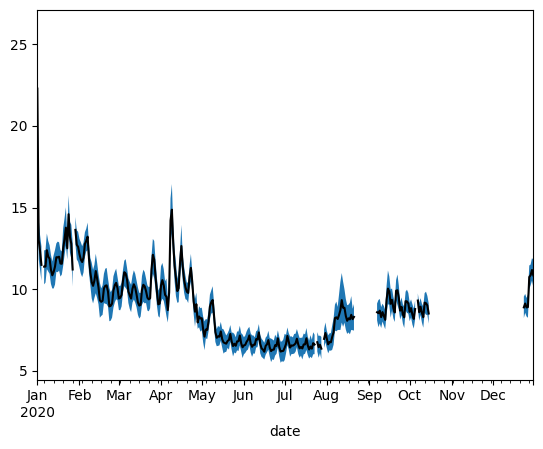

In [41]:
fig,ax=plt.subplots()
df_dew_unc_h2o.resample('1D').mean()['mean'].plot(c='k')
ax.fill_between(df_dew_unc_h2o.resample('1D').mean().index,df_dew_unc_h2o.resample('1D').mean()['lower_bound'],
                df_dew_unc_h2o.resample('1D').mean()['upper_bound'])
